# Source code

This file contains functions used in the different codes of the proyect. A list of the classes and functions with a brief description of them will be included below.

In [230]:
from qutip import *
import numpy as np
import scipy as scipy
import os
from tqdm import tqdm
import sys

In [231]:
"""

Ejemplo de descripción

A class representing a quantum model with open-system dynamics.

Attributes:
-----------
    H (qobj): The system Hamiltonian.
    c_ops (list of qobj): List of collapse operators representing system-environment interactions.
    J (array): Jump matrix corresponding to collapse operators.
    L (qobj): Liouvillian operator representing the full dynamics.
    psi0 (qobj): Initial state of the quantum system.
    Lhat (qobj): Modified Liouvillian by subtracting the Jump matrix.
    rho0 (array): Vectorized initial density matrix.
    Ehat (array or None): Eigenvalue matrix of the modified Liouvillian (Lhat).
    Einvhat (array or None): Inverse of the Eigenvalue matrix (Ehat) if available.
    eigs_hat (array or None): Eigenvalues of the modified Liouvillian (Lhat).

Methods:
-----------
    simulateTrajectories(self, tfin=float, ntraj=int, tlistexp=None, seed=None):
        Generates an array of Monte Carlo jumps from the given quantum model.

    simulateTrajectoryFixedJumps(self, njumpsMC=48):
        Simulate a single quantum trajectory with a fixed total number of quantum jumps.

    computeLikelihood(self, data: np.array, r: float = 5.0, tfin=-1, method="spectral") -> np.array:
        Returns the likelihood function L(D|model) proportional to the probability of the data D being measured,
        given a particular model (Hamiltonian + quantum jump operators).
"""

'\n\nEjemplo de descripción\n\nA class representing a quantum model with open-system dynamics.\n\nAttributes:\n-----------\n    H (qobj): The system Hamiltonian.\n    c_ops (list of qobj): List of collapse operators representing system-environment interactions.\n    J (array): Jump matrix corresponding to collapse operators.\n    L (qobj): Liouvillian operator representing the full dynamics.\n    psi0 (qobj): Initial state of the quantum system.\n    Lhat (qobj): Modified Liouvillian by subtracting the Jump matrix.\n    rho0 (array): Vectorized initial density matrix.\n    Ehat (array or None): Eigenvalue matrix of the modified Liouvillian (Lhat).\n    Einvhat (array or None): Inverse of the Eigenvalue matrix (Ehat) if available.\n    eigs_hat (array or None): Eigenvalues of the modified Liouvillian (Lhat).\n\nMethods:\n-----------\n    simulateTrajectories(self, tfin=float, ntraj=int, tlistexp=None, seed=None):\n        Generates an array of Monte Carlo jumps from the given quantum mo

In [268]:
class squeezed_lasing:

    def __init__(self,delta_s=None,delta_sigma=None,g_0=None,P=None,k=None,N=300,theta=np.pi,r=0,eta=0,omega=0,phi=0):

        # Initialize the squeezed_lasing class

        self.a_s = tensor(destroy(N),identity(2)) # Annihilation operator in squeezed basis
        self.a = self.a_s*np.cosh(r)-np.exp(-1j*theta)*self.a_s.dag()*np.sinh(r)# Annihilation operator in squeezed basis
        self.sigma = tensor(identity(N),basis(2,0)*basis(2,1).dag()) # Lowering operator
        self.delta_s = delta_s
        self.delta_sigma = delta_sigma
        self.g_0 = g_0
        self.P = P
        self.k = k
        self.N = N
        self.theta = theta
        self.r = r
        self.eta = eta
        self.omega = omega
        self.phi = phi

    def def_H(self):
        a_s = self.a_s; sigma = self.sigma; delta_s = self.delta_s; delta_sigma = self.delta_sigma; g_0 = self.g_0; r = self.r; omega = self.omega; phi = self.phi;

        return delta_s*a_s.dag()*a_s+delta_sigma*sigma.dag()*sigma+g_0*np.cosh(r)*(a_s.dag()*sigma+a_s*sigma.dag())+omega*(a_s*np.exp(1j*phi)+a_s.dag()*np.exp(-1j*phi)) # Hamiltonian of the system in the squeezed basis
    
    def def_Lops(self):
        a_s = self.a_s; sigma = self.sigma; P = self.P; k = self.k; eta = self.eta;
        # Collapse operator for incoherent pumping
        # Collapse operator for photon decay
        return [np.sqrt(P)*sigma.dag(),np.sqrt(k*(1+eta))*a_s]

    def calc_rho_sss(self):
        delta_s = self.delta_s; delta_sigma = self.delta_sigma; g_0 = self.g_0; P = self.P; k = self.k; r = self.r; eta = self.eta; omega = self.omega; phi = self.phi;

        H = self.def_H()
        Lops = self.def_Lops()

        return steadystate(H,Lops) # Density matrix in the squeezed basis of the steadystate 
    
    def calc_rho_bss(self,rho=None):
        a = self.a; delta_s = self.delta_s; delta_sigma = self.delta_sigma; g_0 = self.g_0; P = self.P; k = self.k; theta = self.theta; r = self.r; eta = self.eta; omega = self.omega; phi = self.phi;
        self.chi = r*np.exp(-1j*theta) 
        self.S = (0.5*(self.chi*a*a-np.conj(self.chi)*a.dag()*a.dag())).expm() # Squeezing operator

        if rho is None:
            return self.S*self.calc_rho_sss()*self.S.dag() # Steady states in the bare basis
        else:
            return self.S*rho*self.S.dag() # Steady states in the bare basis
    
    def no_squeezed_ev(self,rho,n_dag,n):
        a_s = self.a_s;

        return expect(a_s.dag()**n_dag*a_s**n,rho)
    
    def no_bare_ev(self,rho,n_dag,n):
        a = self.a;

        return expect(a.dag()**n_dag*a**n,rho)
    
    def corr_2(self,rho,tau_f=25):
        a = self.a; k = self.k;

        self.tau_vec = np.linspace(0,tau_f/k,10000) # Time vector of delays
        H = self.def_H()
        Lops = self.def_Lops()
        
        self.corr2 = correlation_3op_1t(H, None, self.tau_vec, Lops, a.dag(), a.dag()*a, a)

        return self.tau_vec, self.corr2/(self.no_bare_ev(rho,1,1))**2
    
    def emis_spec(self,tau_f=25):
        a = self.a; k = self.k;

        self.tau_vec = np.linspace(0,tau_f/k,100) # Time vector of delays
        H = self.def_H()
        Lops = self.def_Lops()
        corr = correlation_2op_1t(H, None, self.tau_vec, Lops, a.dag(), a, options=Options(nsteps=100000))
        wlist, spec = spectrum_correlation_fft(self.tau_vec,corr)

        return wlist, spec
    
    def phot_dist(self,rho):

        return rho.ptrace(0).diag()
    
    def quad_unc(self,quad_ang,rho):
        a = self.a;
        X_ang = a*np.exp(1j*quad_ang)+a.dag()*np.exp(-1j*quad_ang)

        return expect(X_ang**2,rho)-expect(X_ang,rho)**2 # Fluctuations of the quadrature
    
    def Liouv_eigval(self,):
        H = self.def_H()
        Lops = self.def_Lops()
        
        return liouvillian(H,Lops).eigenenergies()
    
    def squeezed_spec(self,quad_ang,rho,tau_f=25,t_f=10):
        a = self.a; k = self.k; theta = self.theta; r = self.r; phi = self.phi; N = self.N;
        
        H = self.def_H()
        Lops = self.def_Lops()
        self.tau_vec = np.linspace(0,tau_f/k,100) # Time vector of delays
        self.t_vec = np.linspace(0,t_f/k,10) # Time vector of times
        self.X_ang = a*np.exp(-1j*quad_ang)+a.dag()*np.exp(1j*quad_ang)
        alpha = np.sqrt(self.no_bare_ev(rho,1,1))*np.exp(1j*phi)
        psi_0 = displace(N,alpha)*basis(N)
        rho_0 = tensor(psi_0*psi_0.dag(),basis(2,1)*basis(2,1).dag())

        # corr = np.exp(-1j*2*quad_ang)*correlation_2op_2t(H, rho_0, self.t_vec, self.tau_vec, Lops, a, a, options=Options(nsteps=10000))+correlation_2op_2t(H, rho_0, self.t_vec, self.tau_vec, Lops, a, a.dag(), options=Options(nsteps=10000))+correlation_2op_2t(H, rho_0, self.t_vec, self.tau_vec, Lops, a.dag(), a, options=Options(nsteps=10000))+np.exp(1j*2*quad_ang)*correlation_2op_2t(H, rho_0, self.t_vec, self.tau_vec, Lops, a.dag(), a.dag(), options=Options(nsteps=10000))
        corr = correlation_2op_2t(H, rho_0, self.t_vec, self.tau_vec, Lops, self.X_ang, self.X_ang, options=Options(nsteps=10000))
        mean_t = mesolve(H, rho_0, self.t_vec, Lops, [self.X_ang], options=Options(nsteps=10000)).expect[0]
        if mean_t[2] == 0:
            print('A')

        spec = np.zeros([np.size(self.t_vec),np.size(self.tau_vec)])
        for i in range(np.size(self.t_vec)):
            mean_ttau = mesolve(H, rho_0, self.t_vec[i]*np.ones(np.size(self.tau_vec))+self.tau_vec, Lops, [self.X_ang], options=Options(nsteps=10000)).expect[0]
            wlist, spec[i,:] = spectrum_correlation_fft(self.tau_vec,corr[i]-(mean_t[i]*np.ones(np.size(self.tau_vec)))*mean_ttau)    
        return self.t_vec, wlist, k*spec-np.ones(np.shape(spec))

In [233]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

In [234]:
class wigner_rep:

    def __init__(self,rhos = None,params: list = None):
        if rhos is None:
            self.delta_s = params[0]
            self.delta_sigma = params[1]
            self.g_0 = params[2]
            self.P = params[3]
            self.k = params[4]
            self.N = params[5]
            self.theta = params[6]
            self.r = params[7]
            self.eta = params[8]
            self.omega = params[9]
            self.phi = params[10]   

            sl = squeezed_lasing(self.delta_s,self.delta_sigma,self.g_0,self.P,self.k,self.N,self.theta,self.r,self.eta,self.omega,self.phi)
            self.H = sl.def_H()
            self.Lops = sl.def_Lops()
            self.rho = sl.calc_rho_bss()
        else:
            self.rhos = rhos
            
    def wigner_calc(self,rho,x_lim,p_lim):
        wig_xvec = np.linspace(-x_lim,x_lim,100) # Values of x in the phase space
        wig_pvec = np.linspace(-p_lim,p_lim,100) # Values of p in the phase space
        Wigner = wigner(rho.ptrace(0),wig_xvec,wig_pvec) # Calculation of the Wigner function

        return wig_xvec, wig_pvec, Wigner

    def wigner_plot(self,x_lim,p_lim):
        rho = self.rhos;

        wig_xvec, wig_pvec, Wigner = self.wigner_calc(rho,x_lim,p_lim)

        if np.isnan(Wigner.max()).any()==True or np.isnan(Wigner.min()).any()==True:
            sys.exit('Warning: NaN encountered in the calculation of Wigner. Change axis limits.')
        else:
            nrm_lim = Wigner.max()

        nrm = mpl.colors.Normalize(-nrm_lim,nrm_lim) # Colorbar settings

        fig, ax = plt.subplots()
        
        cbar = fig.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.RdBu_r),cax = ax.inset_axes([1.05, 0.1, 0.05, 0.8]))
        cbar.set_label('W(x,p)',fontsize=14)
        ax.contourf(wig_xvec, wig_pvec, Wigner, 100, cmap=cm.RdBu_r, norm=nrm) # Plot of the Wigner

        plt.xlim([np.min(wig_xvec),np.max(wig_xvec)]) # Figure settings
        plt.ylim([np.min(wig_pvec),np.max(wig_pvec)])
        plt.title('Steady state Wigner function',fontsize=14)
        plt.axis('scaled')
        plt.xlabel('x',fontsize=14)
        plt.ylabel('p',fontsize=14)
        plt.show()

    def wigner_animation(self,x_lim,p_lim,figname: str = 'Wig',speed = 100, moving_param: np.array = None, mrname: str = None):
        rhos = self.rhos;

        def update_Wigner(num,x_lim,p_lim,mrname,moving_param):
            wig_xvec, wig_pvec, Wigner = self.wigner_calc(rhos[num],x_lim,p_lim)

            ax.cla()
            
            if np.isnan(Wigner.max()).any()==True or np.isnan(Wigner.min()).any()==True:
                sys.exit('Warning: NaN encountered in the calculation of Wigner. Change axis limits.')
            else:
                nrm_lim = Wigner.max()
            nrm = mpl.colors.Normalize(-nrm_lim,nrm_lim) # Colorbar settings
            
            cbar = plt.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.RdBu),cax = ax.inset_axes([1.05, 0.1, 0.05, 0.8])) # Colorbar settings
            cbar.set_label(label='$W(x,p)$',fontsize = 10)
            
            ax.contourf(wig_xvec, wig_pvec, Wigner, 100, cmap=cm.RdBu, norm=nrm)

            ax.set_xlim([np.min(wig_xvec),np.max(wig_xvec)])
            ax.set_ylim([np.min(wig_pvec),np.max(wig_pvec)])
            ax.set_title('Evolution of the Wigner function ('+mrname+' = '+str(format(moving_param[num],'.3f'))+')')
            ax.set_xlabel('x')
            ax.set_ylabel('p')
            ax.axis('scaled')

        im,ax = plt.subplots(figsize=(x_lim/2+1.6,p_lim/2))

        wig_xvec, wig_pvec, Wigner = self.wigner_calc(rhos[0],x_lim,p_lim)

        if np.isnan(Wigner.max()).any()==True or np.isnan(Wigner.min()).any()==True:
            sys.exit('Warning: NaN encountered in the calculation of Wigner. Change axis limits.')
        else:
            nrm_lim = Wigner.max()
        nrm = mpl.colors.Normalize(-nrm_lim,nrm_lim) # Color norm settings
        
        ax.contourf(wig_xvec, wig_pvec, Wigner, 100, cmap=cm.RdBu, norm=nrm)

        cbar = im.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.RdBu),cax = ax.inset_axes([1.05, 0.1, 0.05, 0.8])) # Colorbar settings
        cbar.set_label(label='$W(x,p)$',fontsize = 10)

        animW = animation.FuncAnimation(im, update_Wigner, range(np.ma.size(rhos,0)), fargs = (x_lim,p_lim, mrname, moving_param, ), interval = speed)
        animW.save(str(figname)+'_WIGNER.gif') 

In [245]:
N = 70 # Dimension of the Hilbert space of the cavity
n_q = 100 # Photon saturation number
g_0 = 1 # light-matter coupling
C = 1.64 # Cooperativity (equal to the pumping parameter p)
k = g_0*np.sqrt(2/(C*n_q)) # Photon decay rate
P = 2*n_q*k # Incoherent pumping
eta = 0 # Photon loss due to other decay channels
r = 0.45 # Squeezing parameter
theta = np.pi # Squeezing angle
alpha = (np.e**(4*r)-1)/(np.e**(4*r)+1) # omega_p/delta_c
delta_c = 0 # Detuning w_c-w_p
omega_p = alpha*delta_c # Amplitude of the coherent drive (down-conversion)
delta_s = 0 #delta_c*np.sqrt(1-(omega_p/delta_c)**2) # Detuning in the squeezed basis
delta_sigma = delta_s # Detuning w_sigma-w_p (the same as delta_c to apply RWA)
C_s = C*np.cosh(r)**2 # Squeezed cooperativity (equal to the squeezed pumping parameter p_s)
phi = (theta+np.pi)/2
omega = 0

In [269]:
rho_ss_sb = [] # Steady states of the system in the squeezed basis
rho_bare_ss_sb = [] # Steady states of the system in the bare basis
n_dist = [] # Photon number distribution in the squeezed basis

for i in tqdm(range(np.size(phi))):
    params = squeezed_lasing(delta_s,delta_sigma,g_0,P,k,N,theta,r,eta,omega,phi) # Intialize the calculation with its parameters
    rho_ss_sb.append(params.calc_rho_sss()) # Calculate the density matrix in the squeeze basis
    rho_bare_ss_sb.append(params.calc_rho_bss(rho = rho_ss_sb[i])) # Calculate the density matrix in the bare basis
for i in tqdm(range(np.size(phi))):
    n_dist.append(squeezed_lasing().phot_dist(rho_ss_sb[i]))  # Save the diagonal terms of the density matrix

100%|██████████| 1/1 [00:00<00:00, 125.00it/s]


In [273]:
t, freqs, spec = squeezed_lasing(delta_s,delta_sigma,g_0,P,k,N,theta,r,eta,omega,phi).squeezed_spec((theta+np.pi)/2,rho_ss_sb[0],tau_f=4)

In [274]:
np.min(spec)

0.82748521530626

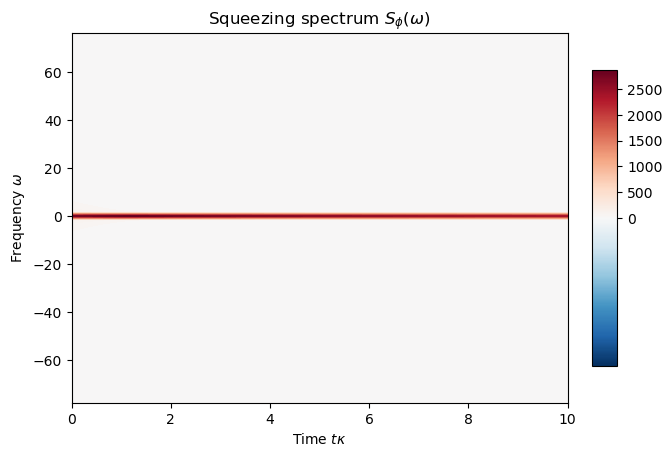

In [275]:
nrm = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=np.max(spec)) # Colorbar settings

fig, ax = plt.subplots()

cbar = plt.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.RdBu_r), cax = ax.inset_axes([1.05, 0.1, 0.05, 0.8]))
ax.contourf(t*k, freqs/k, np.transpose(spec), 100, cmap=cm.RdBu_r, norm=nrm)
ax.set_xlabel(r'Time $t\kappa$')
ax.set_ylabel(r'Frequency $\omega$')
plt.title(r'Squeezing spectrum $S_{\phi}(\omega)$')
plt.show()

(-1.0, 2.0)

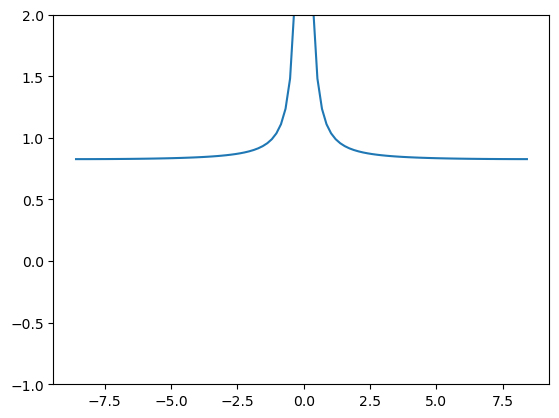

In [277]:
plt.plot(freqs,spec[9])
#plt.plot(freqs,np.zeros(np.size(freqs)),'--')
plt.ylim([-1,2])